<a href="https://colab.research.google.com/github/dookda/gisnorth_openhouse/blob/main/roof_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install python package
!pip install pandas numpy matplotlib seaborn pytest-warnings PyYAML random Pillow opencv-python
!pip install ultralytics
!pip install geopandas
!pip install rasterio
!pip install shapely
!pip install pyproj
!pip install folium
!pip install ipyleaflet

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


In [ ]:
!cp "/content/drive/MyDrive/_DATASET/tms_to_geotiff.py" /content/
!cp "/content/drive/MyDrive/_DATASET/model_Google.pt" /content/

!ls -l /content/tms_to_geotiff.py /content/model_Google.pt

In [23]:
import os
import shutil
import torch
from tms_to_geotiff import tms_to_geotiff
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape, mapping
import geopandas as gpd
import pandas as pd
import numpy as np
from datetime import datetime
import shutil

In [41]:
from ipyleaflet import Map, DrawControl
from datetime import datetime

# 2. declare a global to hold the bbox
bbox = None

# 3. create the map
m = Map(center=(18.79, 98.98), zoom=16)

# 4. add only rectangle draw tools
dc = DrawControl(
    rectangle={"shapeOptions": {"color": "#ff0000"}},
    polygon={}, polyline={}, circle={}, marker={}, circlemarker={}
)
dc.edit = False

# 5. callback writes into the global `bbox`
def handle_draw(target, action, geo_json):
    global bbox
    coords = geo_json["geometry"]["coordinates"][0]
    lons = [pt[0] for pt in coords]
    lats = [pt[1] for pt in coords]
    bbox = (min(lons), min(lats), max(lons), max(lats))
    print(f"[west, south, east, north] = {bbox}  @ {datetime.now()}")

dc.on_draw(handle_draw)

# 6. attach and display
m.add_control(dc)
m


Map(center=[18.79, 98.98], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

[west, south, east, north] = (98.97583, 18.789033, 98.977826, 18.790536)  @ 2025-05-13 00:42:34.660088


In [50]:
print(list(bbox))
bbox = list(bbox)
image = 'satellite.tif'
tms_to_geotiff(output=image, bbox=bbox, zoom=20, source='Satellite', overwrite=True)

[98.97583, 18.789033, 98.977826, 18.790536]
 01/35
 02/35
 03/35
 04/35
 05/35
 06/35
 07/35
 08/35
 09/35
 10/35
 11/35
 12/35
 13/35
 14/35
 15/35
 16/35
 17/35
 18/35
 19/35
 20/35
 21/35
 22/35
 23/35
 24/35
 25/35
 26/35
 27/35
 28/35
 29/35
 30/35
 31/35
 32/35
 33/35
 34/35
 35/35
Saving GeoTIFF. Please wait...
Image saved to satellite.tif


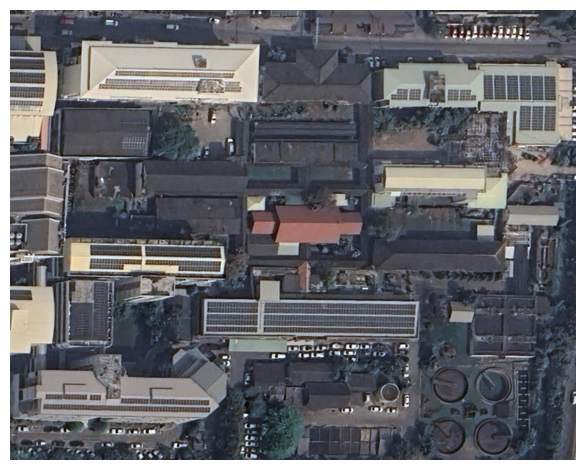

In [51]:
# show image
image = cv2.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.tight_layout()
plt.show()


image 1/1 /content/satellite.tif: 512x640 40 Cement Roofs, 22 Metal roofs, 5546.6ms
Speed: 5.2ms preprocess, 5546.6ms inference, 375.5ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/segment/predict


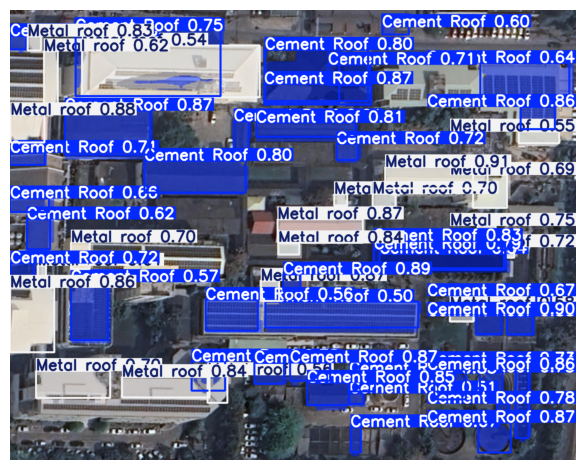

In [52]:
# Load a pretrained model
model = YOLO("model_Google.pt")

# Run inference on 'bus.jpg' with arguments
results = model.predict("satellite.tif", save=True, imgsz=640, conf=0.5)
# results = bestModel.predict(source=imagePath, imgsz=640)

annotatedImage = results[0].plot()
annotatedImageRGB = cv2.cvtColor(annotatedImage, cv2.COLOR_BGR2RGB)
plt.imshow(annotatedImageRGB)
plt.axis('off')
plt.tight_layout()
plt.show()

In [57]:
import os
import shutil
import torch
from tms_to_geotiff import tms_to_geotiff
from ultralytics import YOLO
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape
import geopandas as gpd
import pandas as pd
from datetime import datetime
import folium
from IPython.display import display, HTML

def roofdetect():
    image = 'satellite.tif'

    model = YOLO("model_Google.pt")
    results = model.predict(image, save=True, imgsz=640, conf=0.5)

    with rasterio.open(image) as src:
        transform = src.transform
        crs = src.crs
        height, width = src.height, src.width

    gdfs = []
    for i, mask in enumerate(results[0].masks.data):
        mask = mask.cpu().numpy().astype('uint8')
        class_index = int(results[0].boxes.cls[i])
        label = results[0].names[class_index]

        output_file = f"segment_{i+1}.tif"
        with rasterio.open(
            output_file,
            "w",
            driver="GTiff",
            height=height,
            width=width,
            count=1,
            dtype=mask.dtype,
            crs=crs,
            transform=transform,
        ) as dst:
            dst.write(mask, 1)

        with rasterio.open(output_file) as src:
            mask_data = src.read(1)
            shapes_gen = shapes(mask_data, transform=src.transform)
            polygons = [shape(geom) for geom, val in shapes_gen if val == 1]
            gdf = gpd.GeoDataFrame(geometry=polygons, crs=crs)
            gdf['label'] = label
            gdfs.append(gdf)
        os.remove(output_file)

    combined_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
    combined_gdf = combined_gdf.to_crs('EPSG:4326')

    m = folium.Map(
        location=[(bbox[1] + bbox[3])/2, (bbox[0] + bbox[2])/2],
        zoom_start=24,
        tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr='Google Satellite'
    )

    # Add detection polygons
    folium.GeoJson(
        combined_gdf,
        name='Roof Detections',
        style_function=lambda x: {
            'color': 'red',
            'weight': 2,
            'fillColor': 'red',
            'fillOpacity': 0.4
        }
    ).add_to(m)
    display(m)
    if os.path.exists('runs'):
        shutil.rmtree('runs')

if __name__ == '__main__':
    roofdetect()


image 1/1 /content/satellite.tif: 512x640 40 Cement Roofs, 22 Metal roofs, 6471.7ms
Speed: 18.1ms preprocess, 6471.7ms inference, 287.4ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/segment/predict
